In [2]:
import numpy as np
species_data = np.load("../data/species.npy", allow_pickle=True)

In [9]:
species_dict = {species_data[i] : i  for i in range(len(species_data))}

In [8]:
species_dict.get(10)

'Junco hyemalis'

In [12]:
species_dict

{'Bombus griseocollis': 0,
 'Euchromius ocellea': 1,
 'Nycticorax nycticorax': 2,
 'Dryophytes versicolor': 3,
 'Branta canadensis': 4,
 'Accipiter cooperii': 5,
 'Papilio glaucus': 6,
 'Ardea alba': 7,
 'Xylocopa virginica': 8,
 'Toxomerus marginatus': 9,
 'Junco hyemalis': 10,
 'Helvella elastica': 11,
 'Stemonitis splendens': 12,
 'Hemerocallis fulva': 13,
 'Persicaria virginiana': 14,
 'Symphoricarpos orbiculatus': 15,
 'Alypia octomaculata': 16,
 'Lespedeza cuneata': 17,
 'Syringa vulgaris': 18,
 'Platycryptus undatus': 19,
 'Zonotrichia albicollis': 20,
 'Agelaius phoeniceus': 21,
 'Diospyros virginiana': 22,
 'Spinus tristis': 23,
 'Estigmene acrea': 24,
 'Catocala palaeogama': 25,
 'Lasiurus borealis': 26,
 'Canis latrans': 27,
 'Sciurus carolinensis': 28,
 'Coleomegilla maculata': 29,
 'Leonurus cardiaca': 30,
 'Anas platyrhynchos': 31,
 'Synanthedon rileyana': 32,
 'Callopistria floridensis': 33,
 'Trametes cinnabarina': 34,
 'Leptoglossus oppositus': 35,
 'Chondestes grammac

In [2]:
import pandas as pd
ica = pd.read_csv('/data/cher/EcoBound/data/ica.csv')

In [5]:
densely_sampled = ica[['lon', 'lat']]
densely_sampled.to_csv('/data/cher/EcoBound/data/densely_sampled_pts.csv')

In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

from dataset import MapDataset

from model import SDM

experiment_name = "STL-full-loc-an_full-128-1024"

# If specific species of interest
species = None # e.g. 'Sciurus carolinensis'

# Model for inference
model = SDM.load_from_checkpoint(f"/data/cher/EcoBound/models/{experiment_name}.ckpt")
model.cuda().eval()

# Densely sampled dataset
mapdataset = MapDataset()
maploader = torch.utils.data.DataLoader(mapdataset, batch_size=128, shuffle=False, num_workers=16)

# Species data is necessary if doing specific species
if species:
    species_data = np.load("/data/cher/EcoBound/data/species.npy", allow_pickle=True)
    species_index = np.where(species_data == species)[0][0]

# Run inference
species_probs = []
with torch.no_grad():
    for batch in tqdm(maploader):
        loc_feats = batch.cuda()
        if species:
            logits = model(loc_feats, class_of_interest=species_index)
        else:
            logits = model(loc_feats)
        probs = torch.sigmoid(logits).cpu().numpy()
        species_probs.append(probs)

species_probs = np.concatenate(species_probs, axis=0)

# if species:
#     np.save(f'/data/cher/EcoBound/outputs/species_priors/{species}-{experiment_name}.npy', species_probs)
# else:
#     np.save(f'/data/cher/EcoBound/outputs/species_priors/{experiment_name}.npy', species_probs)

/home/cher/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2017/2017 [00:03<00:00, 547.70it/s]


In [2]:
species_probs.shape

(258064, 5971)

In [3]:
species_probs.shape

(258064, 5971)

In [4]:
# species_probs2 = np.load("/data/cher/EcoBound/outputs/species_priors/STL-full-loc-an_full-128-1024.npy")
species_probs3 = np.load("/data/cher/EcoBound/outputs/species_priors/STL-full-loc-an_full-128-1024.npy", allow_pickle=True)
(species_probs==species_probs3).all()

True

In [2]:
import pandas as pd
tst = pd.read_csv('/data/cher/EcoBound/data/gbif_full_filtered-test.csv')

/tmp/ipykernel_3553705/1215128261.py:2: DtypeWarning: Columns (12,16,41,42,43,45,48,50) have mixed types. Specify dtype option on import or set low_memory=False.
  tst = pd.read_csv('/data/cher/EcoBound/data/gbif_full_filtered-test.csv')


In [8]:
import numpy as np
tst = np.load('/data/cher/EcoBound/outputs/species_priors/STL-full-loc-max_entropy-128-1024.npy', allow_pickle=True)
tst

array([[0.544233  , 0.4998707 , 0.5534618 , ..., 0.50030833, 0.5003563 ,
        0.4998918 ],
       [0.5442114 , 0.4998707 , 0.5534909 , ..., 0.50030845, 0.50035614,
        0.4998918 ],
       [0.54418117, 0.4998707 , 0.5535317 , ..., 0.50030863, 0.500356  ,
        0.49989167],
       ...,
       [0.45879522, 0.49987182, 0.5126556 , ..., 0.4997086 , 0.49988917,
        0.49999654],
       [0.458892  , 0.49987188, 0.51267385, ..., 0.49970853, 0.49988934,
        0.49999666],
       [0.45896205, 0.499872  , 0.5126869 , ..., 0.49970847, 0.49988928,
        0.49999666]], dtype=float32)

In [6]:
1e-5+4.99e-1

0.49901

In [ ]:
tst.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'gbifID', 'datasetKey', 'occurrenceID',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species',
       'infraspecificEpithet', 'taxonRank', 'scientificName',
       'verbatimScientificName', 'verbatimScientificNameAuthorship',
       'countryCode', 'locality', 'stateProvince', 'occurrenceStatus',
       'individualCount', 'publishingOrgKey', 'decimalLatitude',
       'decimalLongitude', 'coordinateUncertaintyInMeters',
       'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth',
       'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey',
       'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode',
       'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified',
       'license', 'rightsHolder', 'recordedBy', 'typeStatus',
       'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue'],
      dtype='object')

In [13]:
tst[~tst['eventDate'].isna()][['eventDate', 'day', 'month', 'year', 'taxonKey',
       'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode',
       'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified']].sort_values('eventDate')

,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified
226586,2010-01-01,1.0,1.0,2010,2490384,2490384.0,HUMAN_OBSERVATION,CLO,EBIRD,OBS83184237,NaN,NaN,NaN
228266,2010-01-01,1.0,1.0,2010,9149595,9149595.0,HUMAN_OBSERVATION,CLO,EBIRD,OBS442133334,NaN,NaN,NaN
228259,2010-01-01,1.0,1.0,2010,5231140,5231140.0,HUMAN_OBSERVATION,CLO,EBIRD,OBS83184236,NaN,NaN,NaN
228106,2010-01-01,1.0,1.0,2010,2482507,2482507.0,HUMAN_OBSERVATION,CLO,EBIRD,OBS442133335,NaN,NaN,NaN
228021,2010-01-01,1.0,1.0,2010,2484254,2484254.0,HUMAN_OBSERVATION,CLO,EBIRD,OBS442133340,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453599,2024-05-20T13:42:54,20.0,5.0,2024,5173257,5173257.0,HUMAN_OBSERVATION,iNaturalist,Observations,217121125,NaN,cgracebarnett,2024-05-20T18:44:22
2098,2024-05-21T03:20:48,21.0,5.0,2024,2427091,2427091.0,HUMAN_OBSERVATION,iNaturalist,Observations,217369221,NaN,levihartz,2024-05-21T21:31:26
1589,2024-05-21T06:58:01,21.0,5.0,2024,4989904,4989904.0,HUMAN_OBSERVATION,iNaturalist,Observations,217268306,NaN,richyfourtytwo,2024-05-21T12:23:48
1517,2024-05-21T06:58:39,21.0,5.0,2024,4989904,4989904.0,HUMAN_OBSERVATION,iNaturalist,Observations,217268402,NaN,richyfourtytwo,2024-05-21T12:22:22


In [6]:
# After your inference code...

# 1. Get coordinates from the dataset
coords_df = mapdataset.coords.reset_index(drop=True)[['lon', 'lat']]

# 2. Create DataFrame with probabilities
species_names = np.load("/data/cher/EcoBound/data/species.npy", allow_pickle=True)  # Load your species names
prob_df = pd.DataFrame(species_probs, columns=[f"prob_{name}" for name in species_names])

# 3. Combine coordinates with probabilities
results_df = pd.concat([coords_df, prob_df], axis=1)

results_df[['lon', 'lat', 'prob_Sciurus carolinensis']]

# 4. Save to CSV
# results_df.to_parquet('species_predictions.parquet', index=False)

,lon,lat,prob_Sciurus carolinensis
0,-90.093300,38.884327,0.002261
1,-90.094450,38.884327,0.002267
2,-90.095604,38.884327,0.002274
3,-90.096760,38.884327,0.002284
4,-90.097916,38.884327,0.002296
...,...,...,...
258059,-90.674060,38.457690,0.004499
258060,-90.675220,38.457690,0.004495
258061,-90.676370,38.457690,0.004493
258062,-90.677520,38.457690,0.004490


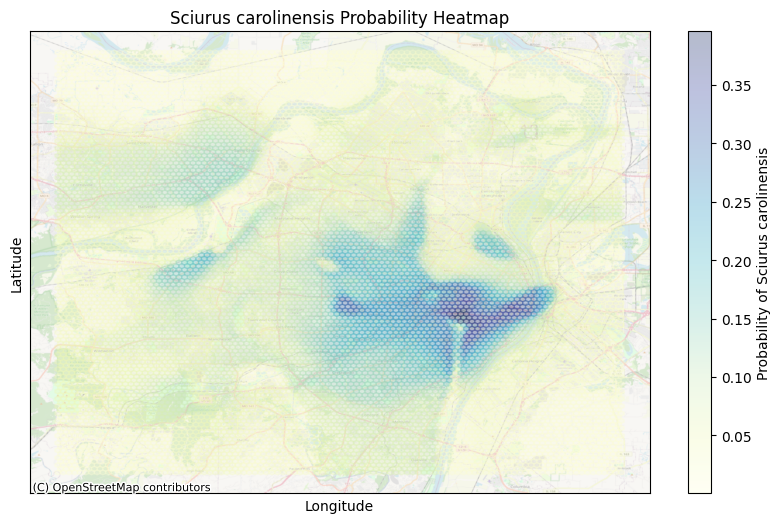

In [13]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

species = 'Sciurus carolinensis'

df = results_df[['lon', 'lat', f'prob_{species}']]
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")  # Convert to Web Mercator

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
hb = ax.hexbin(gdf.geometry.x, gdf.geometry.y, C=df[f"prob_{species}"], 
            gridsize=100, cmap="YlGnBu", reduce_C_function=np.mean, alpha=0.3)

# Add colorbar
plt.colorbar(hb, ax=ax, label=f"Probability of {species}")

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, alpha=0.5)

# Labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"{species} Probability Heatmap")
ax.set_xticks([])
ax.set_yticks([])

plt.show()
# Save plot
# output_path = os.path.join(output_dir, f"{species}-{experiment_name}.png")
# plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close(fig)

# print(f"Saved: {output_path}")

28